# Gaussian Mixture Models
by Marc Deisenroth

In this notebook, we will look at density modeling with Gaussian mixture models (GMMs).
In Gaussian mixture models, we describe the density of the data as
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathcal{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

The goal of this notebook is to get a better understanding of GMMs and to write some code for training GMMs using the EM algorithm. We provide a code skeleton and mark the bits and pieces that you need to implement yourself.

In [2]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from IPython import display

%matplotlib inline

np.random.seed(42)

### Define a GMM from which we generate data
Set up the true GMM from which we will generate data.

In [3]:
# Choose a GMM with 3 components

# means
m = np.zeros((3,2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

# covariances
S = np.zeros((3,2,2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

# mixture weights
w = np.array([0.3, 0.2, 0.5])

Generate some data

In [4]:
N_split = 200 # number of data points per mixture component
N = N_split*3 # total number of data points
x = []
y = []
for k in range(3):
    x_tmp, y_tmp = np.random.multivariate_normal(m[k], S[k], N_split).T 
    x = np.hstack([x, x_tmp])
    y = np.hstack([y, y_tmp])

data = np.vstack([x, y])

Visualization of the dataset

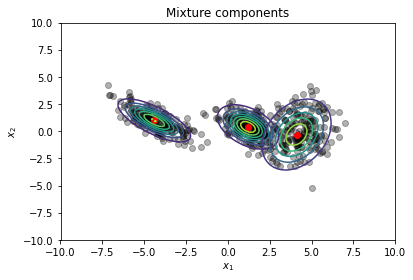

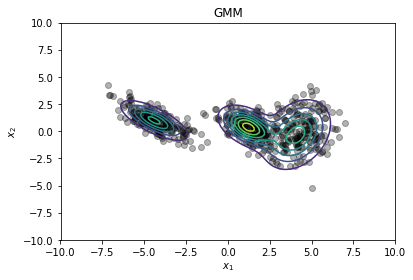

In [14]:
X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

mvn = multivariate_normal(m[0,:].ravel(), S[0,:,:])
xx = mvn.pdf(pos)

# plot the dataset
plt.figure()
plt.title("Mixture components")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# plot the individual components of the GMM
plt.plot(m[:,0], m[:,1], 'or')

for k in range(3):
    mvn = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    xx = mvn.pdf(pos)
    plt.contour(X, Y, xx,  alpha = 1.0, zorder=10)
     
# # plot the GMM 
plt.figure()
plt.title("GMM")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# # build the GMM
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    gmm += w[k]*mix_comp.pdf(pos)
    
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10);

## Train the GMM via EM
### Initialize the parameters for EM

In [15]:
K = 3 # number of clusters
# Define dataset D by stacking x, y
D = np.stack((x, y), axis=1)
means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K
print("Initial mean vectors (one per row):\n" + str(means))

Initial mean vectors (one per row):
[[ 0.1252245  -0.42940554]
 [ 0.1222975   0.54329803]
 [ 0.04886007  0.04059169]]


In [214]:
def calc_nll(D, means, covs, K):
    ll = 0
    mvns = []
    for k in range(K):
        mvn = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
        mvns.append(mvn)
    for d in D:
        zs = np.asarray([mvn.pdf(np.array(d)) for mvn in mvns])
        ll += np.log([sum(w[k] * z for z in zs)])
    return -ll

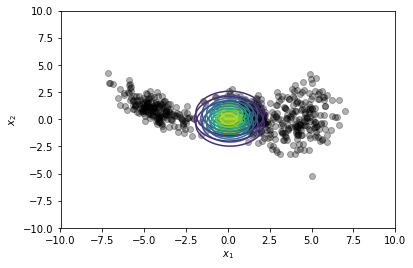

In [227]:
#EDIT THIS FUNCTION
# Calculate negative log likelihood:
# 1. Create multivariate gaussians, one per fixture
# 2. For each data point, evaulate (negative) log likelihood (NLL)

NLL = [] # (negative) log-likelihood of the GMM
mvns = []
for k in range(K):
    mvn = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    mvns.append(mvn)
for d in zip(x, y):
    zs = np.asarray([mvn.pdf(np.array(d)) for mvn in mvns])
    ll += np.log([sum(w[k] * z for z in zs)])
    
NLL += [calc_nll(np.stack((x, y), axis=1), means, covs, K)]

plt.figure()
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
    
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

First, we define the responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ as
$$
r_{nk} := \frac{\pi_k\mathcal N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)} 
          $$

Given the responsibilities we just defined, we can update the model parameters in the M-step as follows:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
where $$
N_k := \sum_{n=1}^N r_{nk}
$$

### EM Algorithm

In [231]:
k = 0
1/N_k[k] * np.array([
            r[k][i] * (D[i] - means[k]).reshape(ndim, -1) @ (D[i] - means[k]).reshape(ndim, -1).T for i in range(N)
        ])

array([[[ 5.74160661e-04, -9.35461861e-04],
        [-9.35461861e-04,  1.52411851e-03]],

       [[ 1.38008829e-05,  1.97204969e-04],
        [ 1.97204969e-04,  2.81792115e-03]],

       [[ 8.24105874e-05, -1.54882056e-04],
        [-1.54882056e-04,  2.91084581e-04]],

       ...,

       [[ 2.38462701e-02, -3.00426986e-02],
        [-3.00426986e-02,  3.78492625e-02]],

       [[ 2.66214708e-02, -1.58725557e-03],
        [-1.58725557e-03,  9.46371541e-05]],

       [[ 4.18243266e-02, -1.12905550e-04],
        [-1.12905550e-04,  3.04790641e-07]]])

<ipython-input-257-1602b24c6917>:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Converged after iteration  52


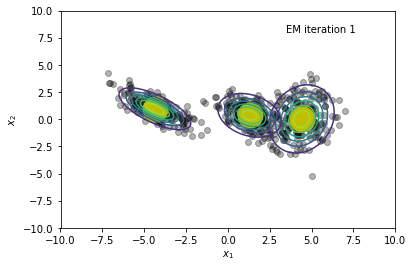

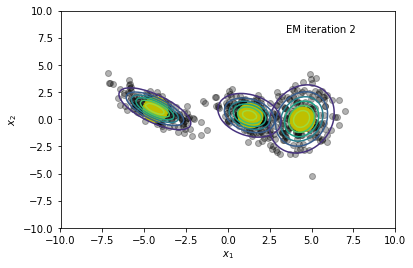

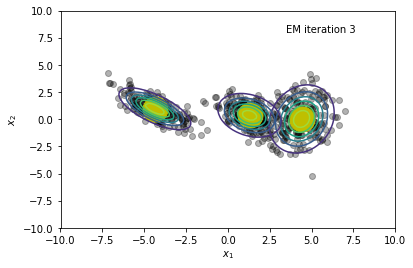

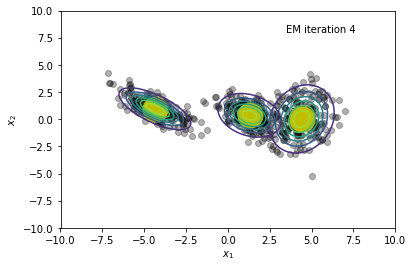

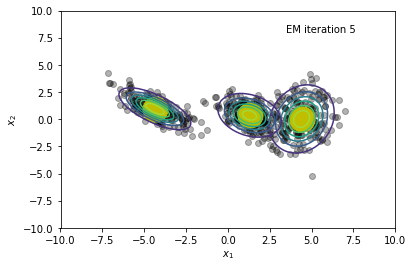

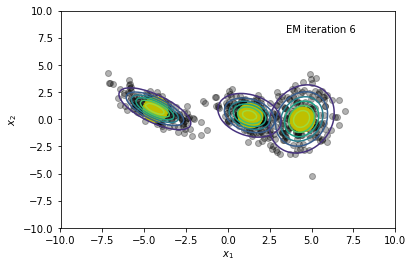

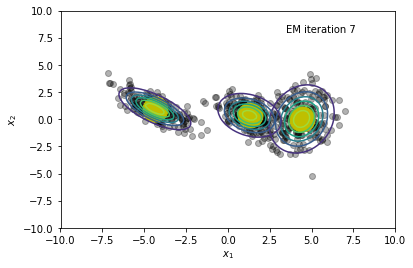

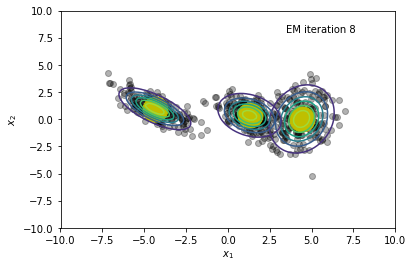

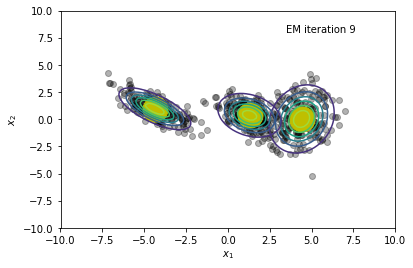

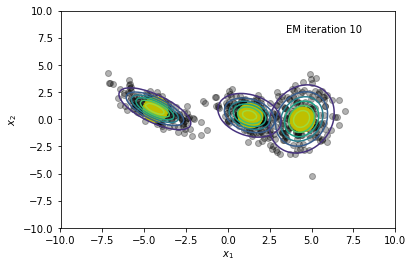

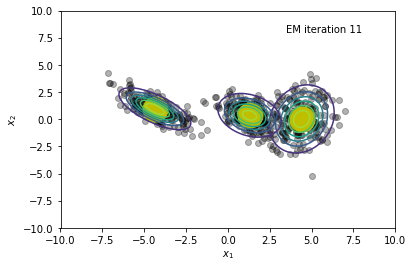

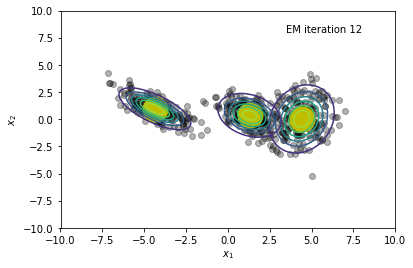

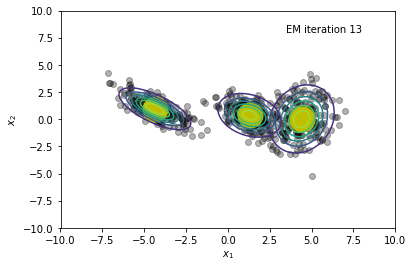

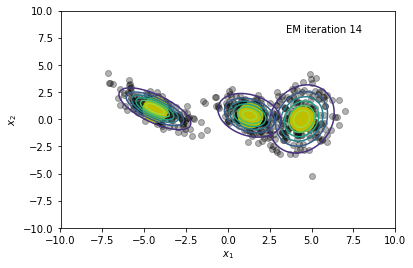

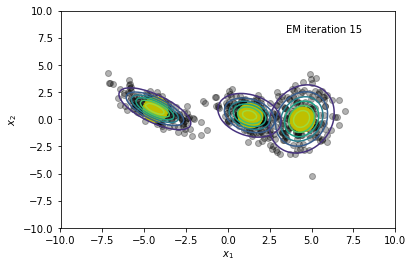

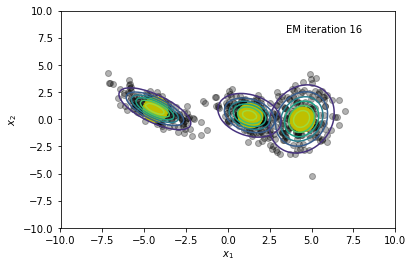

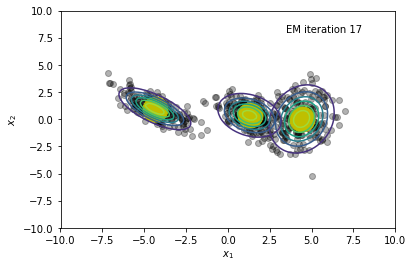

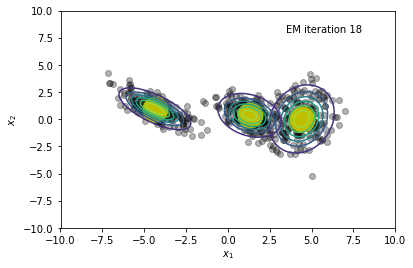

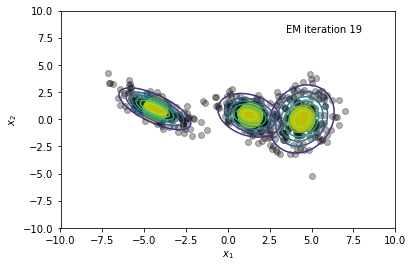

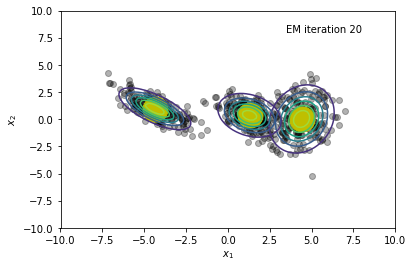

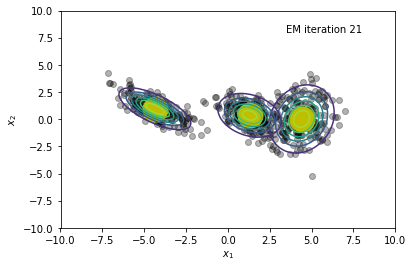

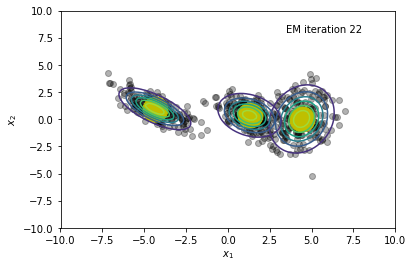

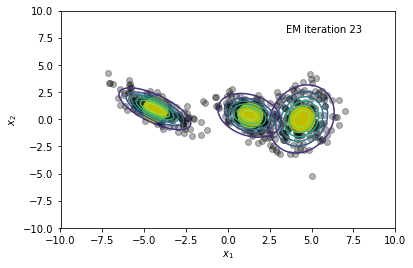

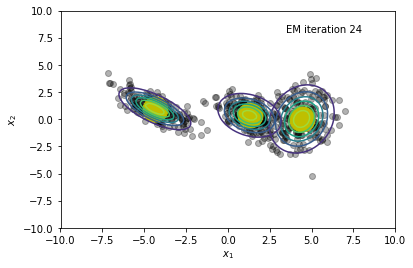

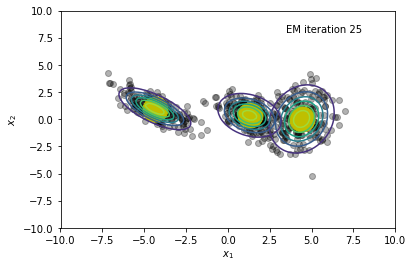

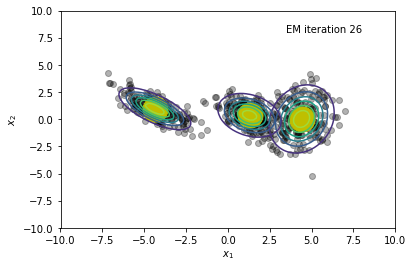

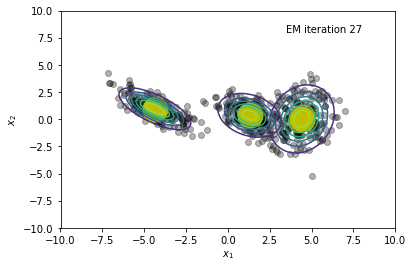

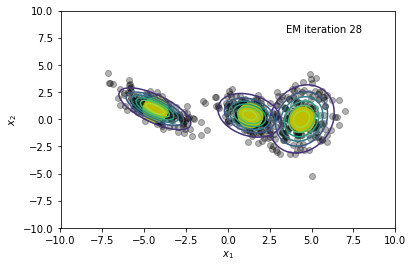

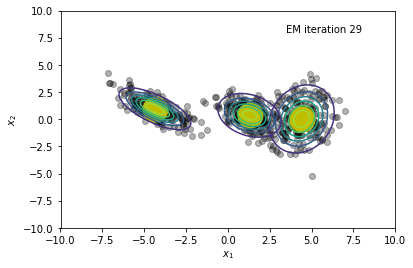

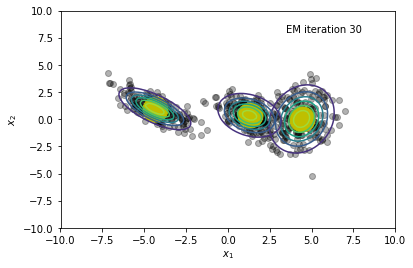

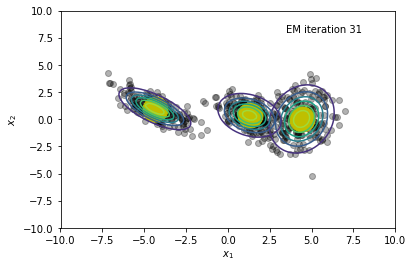

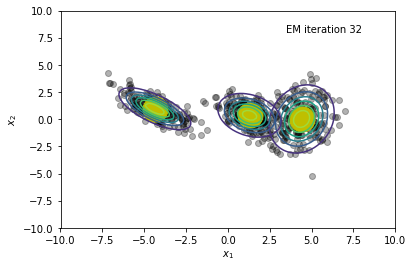

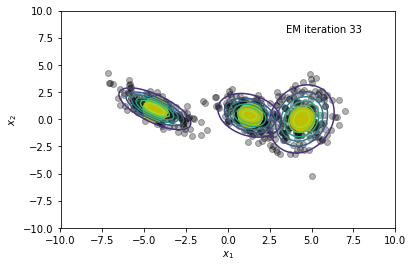

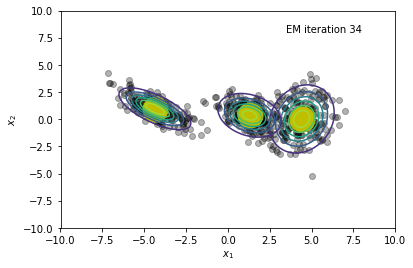

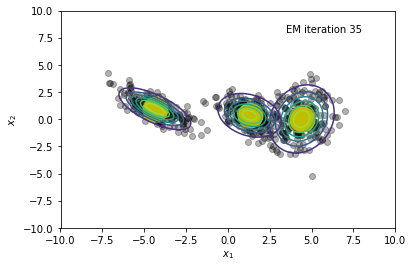

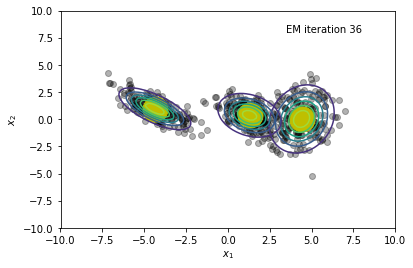

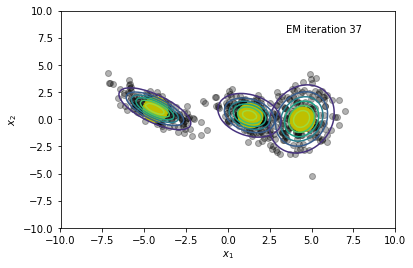

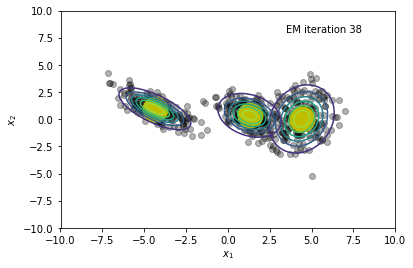

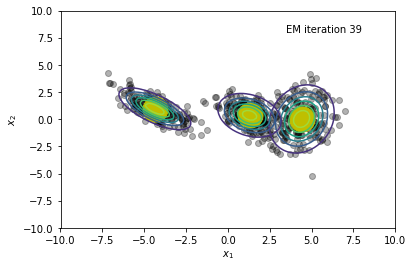

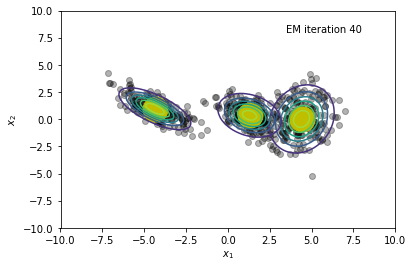

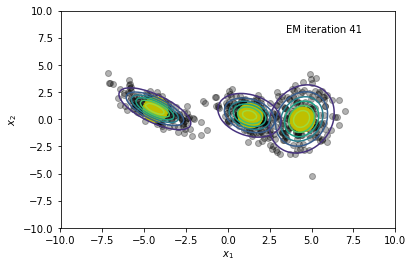

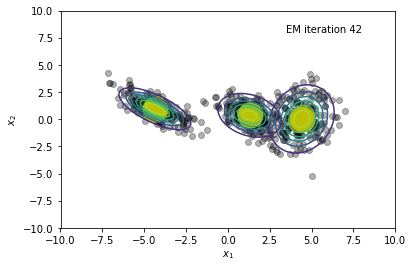

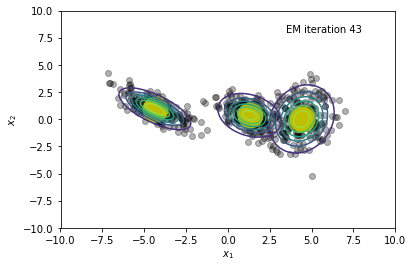

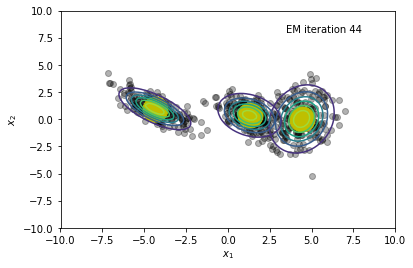

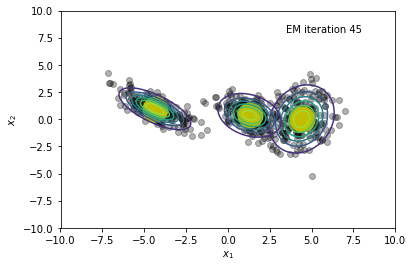

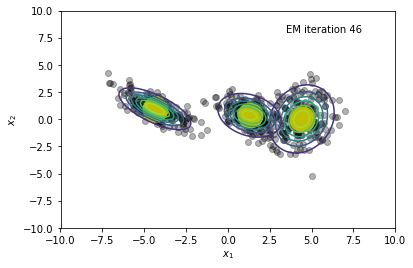

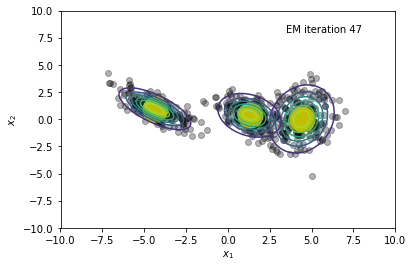

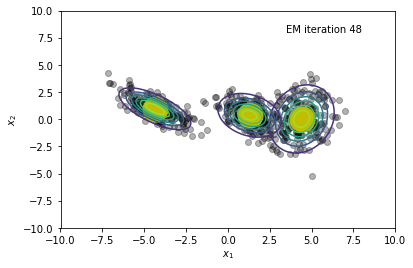

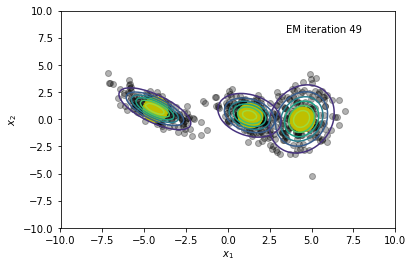

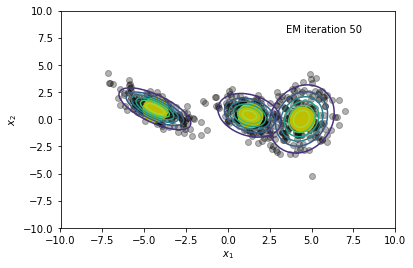

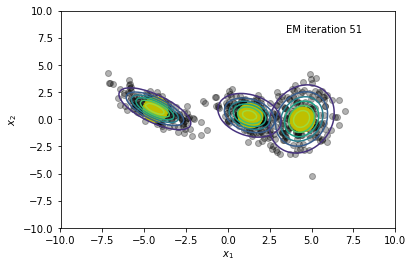

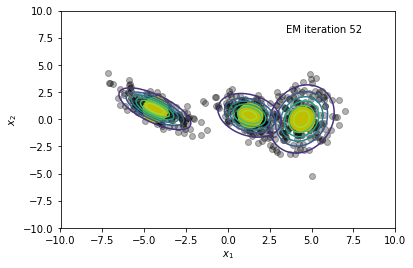

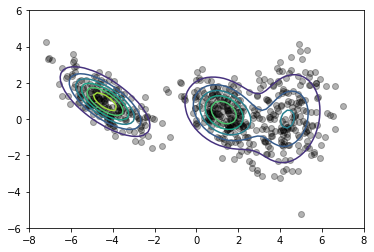

In [257]:
#EDIT THIS FUNCTION
ndim = 2
r = np.zeros((K,N)) # will store the responsibilities
# mvns holds a list with gaussian mixtures

D = np.stack((x, y), axis=1)
for em_iter in range(100):    
    means_old = means.copy()
    
    # E-step: update responsibilities
    r_nominator = np.array([weights[i] * mvns[i].pdf(np.dstack((x, y))) for i in range(K)])
    r = r_nominator / r_nominator.sum(axis=0)  # KxN
        
    # M-step
    N_k = np.sum(r, axis=1)
    
    for k in range(K): 
        # update the means
        means[k] = 1/N_k[k] * np.sum(r[k, :].reshape(N, -1) * np.stack((x, y), axis=1), axis=0)
        
        # update the covariances
        
        a = np.array([r[k][i] * (D[k] - means[k]).reshape(ndim, -1) @ (D[k] - means[k]).reshape(ndim, -1).T for i in range(N)])
        covs[k] = 1/N_k[k] * np.sum(
            np.array([
                r[k][i] * (D[i] - means[k]).reshape(ndim, -1) @ (D[i] - means[k]).reshape(ndim, -1).T for i in range(N)
            ]),
            axis=0
        )
        
    # weights
    weights = np.sum(r, axis=1) / N
    
    # log-likelihood
    NLL += [calc_nll(D, means, covs, K)] #<-- REPLACE THIS LINE
    
    plt.figure() 
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    for k in range(K):
        rv = multivariate_normal(means[k,:], covs[k])
        plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)
        
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.text(x=3.5, y=8, s="EM iteration "+str(em_iter+1))
    
    if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Converged after iteration ", em_iter+1)
        break
   
# plot final the mixture model
plt.figure() 
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    gmm += weights[k]*mix_comp.pdf(pos)

plt.plot(x, y, 'ko', alpha=0.3)
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)    
plt.xlim([-8,8]);
plt.ylim([-6,6]);

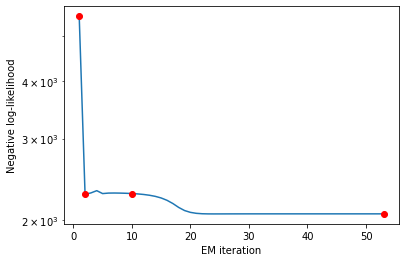

In [256]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("EM iteration");
plt.ylabel("Negative log-likelihood");

idx = [0, 1, 9, em_iter+1]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')